In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline  

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from utils import *
from utils_plotting import plot_embedding, plot_histograms

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

sns.set(style='ticks')
sns.set_palette('cubehelix')

# KiDS

In [4]:
kids_r = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.merged.cols.500k.csv', cut='r')

Data shape: (502439, 37)
Droping NANs: 403753 (80.36%) left
Removing errors bigger than 1: 266766 (53.09%) left
Removing limiting magnitudes: 109011 (21.70%) left
Removing IMA flags: 89450 (17.80%) left
Removing R > 22: 34597 left


In [5]:
kids_c = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.merged.cols.500k.csv', cut='u-g')

Data shape: (502439, 37)
Droping NANs: 403753 (80.36%) left
Removing errors bigger than 1: 266766 (53.09%) left
Removing limiting magnitudes: 109011 (21.70%) left
Removing IMA flags: 89450 (17.80%) left
Removing U-G < 0: 68204 left


In [6]:
kids = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.merged.cols.500k.csv')

Data shape: (502439, 37)
Droping NANs: 403753 (80.36%) left
Removing errors bigger than 1: 266766 (53.09%) left
Removing limiting magnitudes: 109011 (21.70%) left
Removing IMA flags: 89450 (17.80%) left


In [7]:
kids_x_sdss = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv', sdss_cleaning=True)

Data shape: (91317, 49)
Droping NANs: 89513 (98.02%) left
Removing errors bigger than 1: 84491 (92.52%) left
Removing limiting magnitudes: 74191 (81.25%) left
Removing IMA flags: 55787 (61.09%) left
Cleaning SDSS: 52010 left


# R cuts

In [8]:
for r_max in [22, 23, 24, 25, 26]:
    print(r_max, kids.loc[kids[MAG_GAAP_CALIB_R] < r_max].shape)

22 (34597, 47)
23 (60555, 47)
24 (86499, 47)
25 (89450, 47)
26 (89450, 47)


# KiDS magnitudes

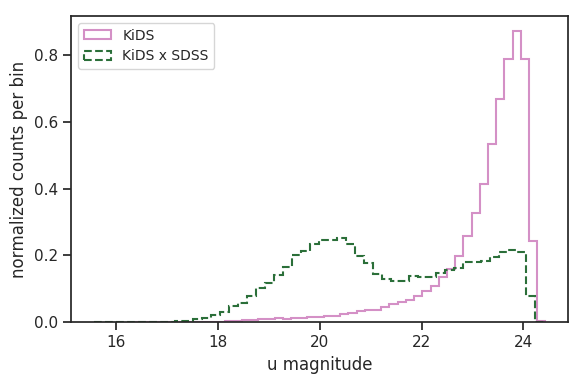

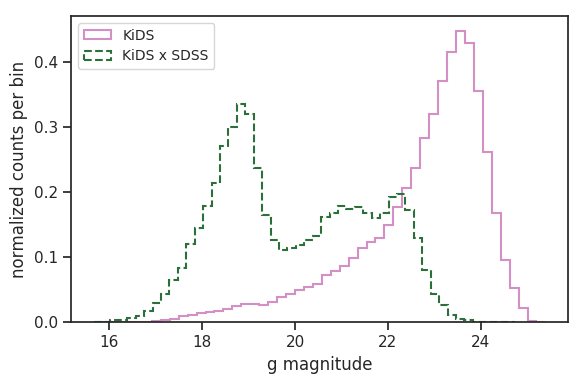

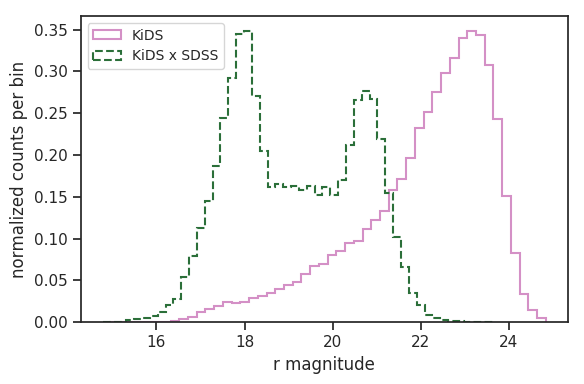

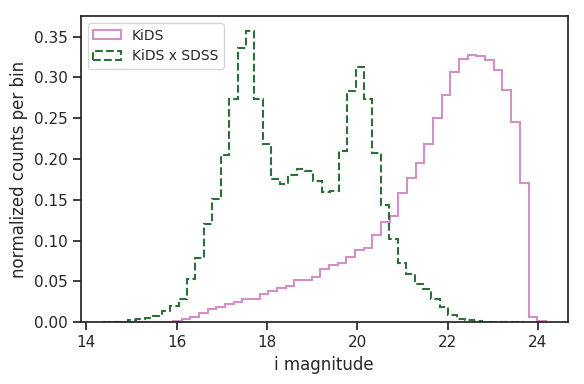

In [10]:
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
plot_histograms(data_dict, BAND_CALIB_COLUMNS, legend_size=10, pretty_print_function=pretty_print_feature)

# KiDS Colors

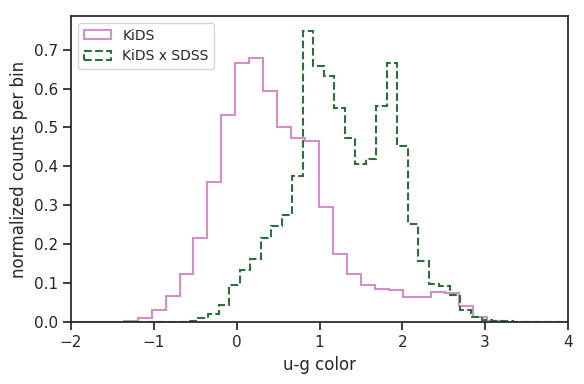

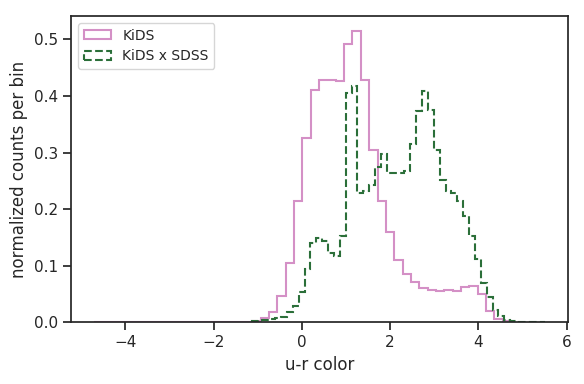

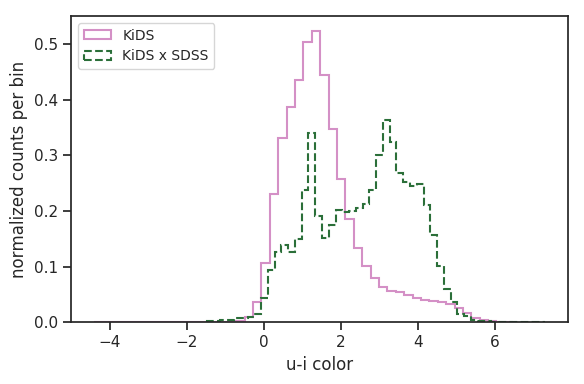

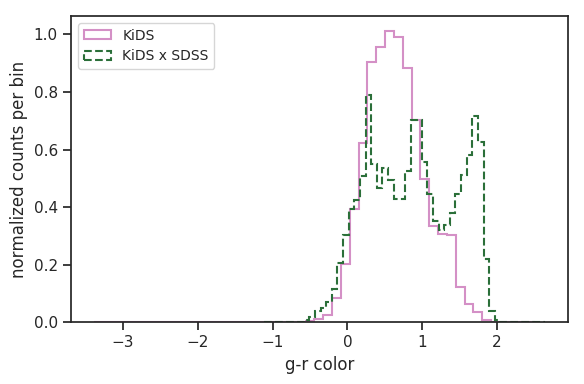

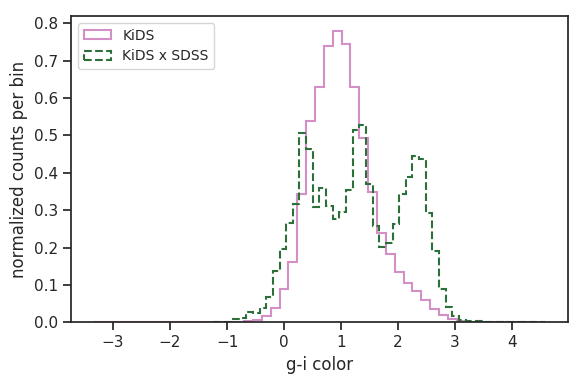

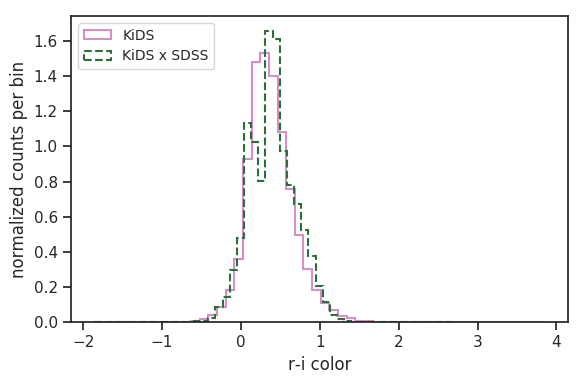

In [11]:
data_dict = OrderedDict([('KiDS', kids), ('KiDS x SDSS', kids_x_sdss)])
x_lim_dict = {COLOR_GAAPHOM_U_G: (-2, 4)}
plot_histograms(data_dict, COLOR_COLUMNS, x_lim_dict=x_lim_dict, legend_size=10, pretty_print_function=pretty_print_feature)

# KiDS ratios

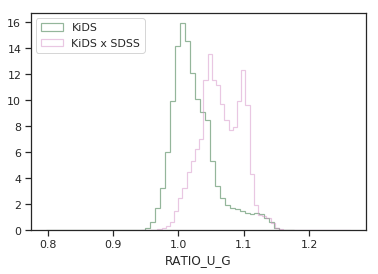

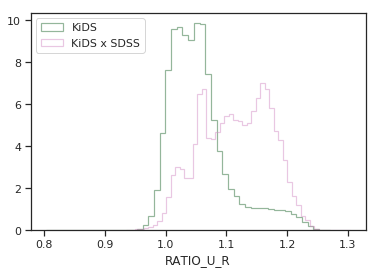

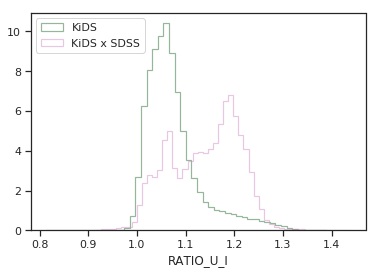

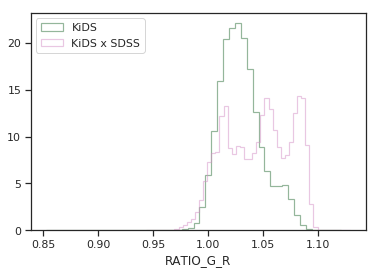

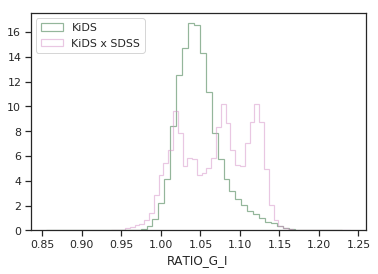

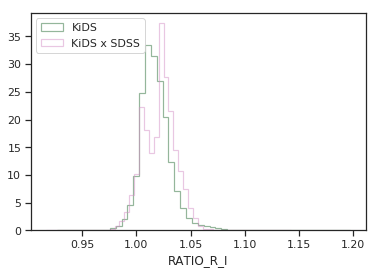

In [38]:
x_lim_dict = {COLOR_GAAPHOM_U_G: (-2, 4)}

for c in RATIO_COLUMNS:
    plt.figure()
    sns.distplot(kids[c], label='KiDS', kde=False, rug=False, norm_hist=True, color=color_palette[0],
                 hist_kws={'alpha': 0.5, 'histtype': 'step', 'linewidth': 1.2})
    sns.distplot(kids_x_sdss[c], label='KiDS x SDSS', kde=False, rug=False, norm_hist=True, color=color_palette[1],
                 hist_kws={'alpha': 0.5, 'histtype': 'step', 'linewidth': 1.2})

    if c in x_lim_dict:
        plt.xlim(x_lim_dict[c][0], x_lim_dict[c][1])
    
    plt.legend(loc='upper left')

# KiDS R < 22

In [39]:
kids_cut = kids.loc[kids[MAG_GAAP_CALIB_R] <= 22]
kids_x_sdss_cut = kids_x_sdss.loc[kids_x_sdss[MAG_GAAP_CALIB_R] <= 22]

In [40]:
print(kids.shape)
print(kids_cut.shape)

(89450, 47)
(34597, 47)


In [41]:
print(kids_x_sdss.shape)
print(kids_x_sdss_cut.shape)

(52010, 59)
(51752, 59)


In [42]:
print(np.unique(kids_x_sdss['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([32582,  7265, 12163]))


In [43]:
print(np.unique(kids_x_sdss_cut['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([32547,  7061, 12144]))


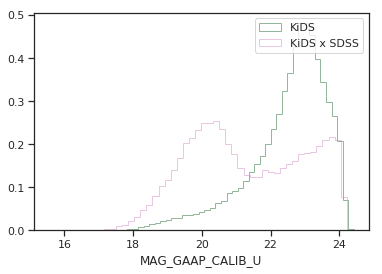

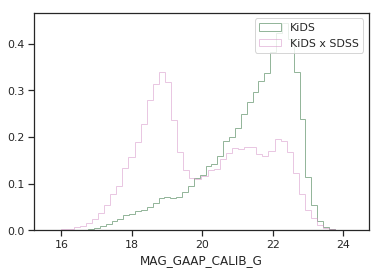

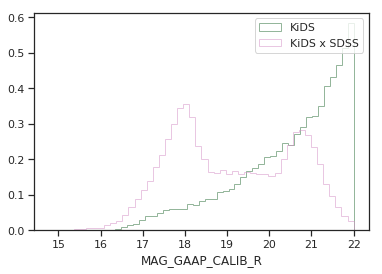

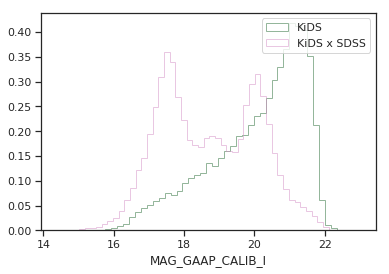

In [44]:
sns.set(style='ticks')
for c in BAND_CALIB_COLUMNS:
    plt.figure()
    sns.distplot(kids_cut[c], label='KiDS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[0])
    sns.distplot(kids_x_sdss_cut[c], label='KiDS x SDSS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[1])
    plt.legend()

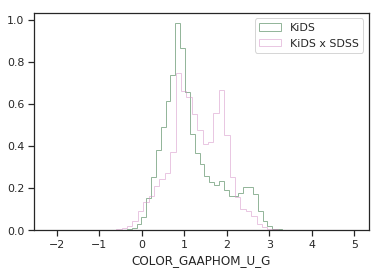

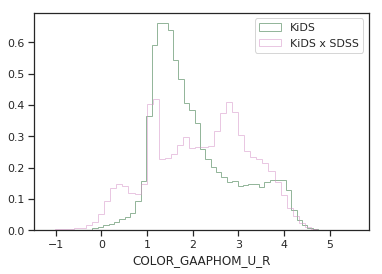

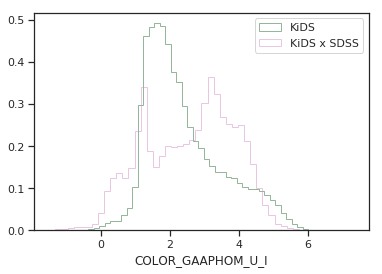

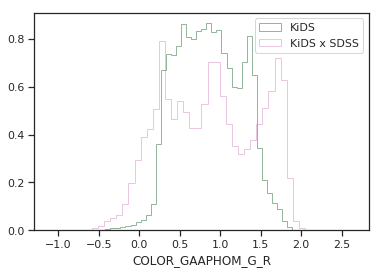

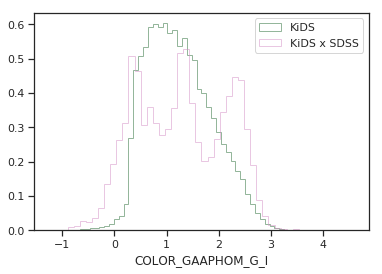

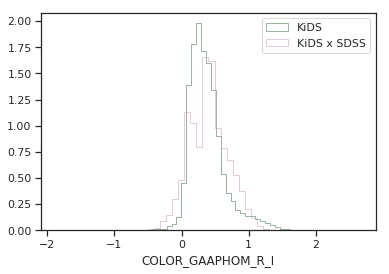

In [45]:
sns.set(style='ticks')
for c in COLOR_COLUMNS:
    plt.figure()
    sns.distplot(kids_cut[c], label='KiDS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[0])
    sns.distplot(kids_x_sdss_cut[c], label='KiDS x SDSS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True,color=color_palette[1])
    plt.legend()

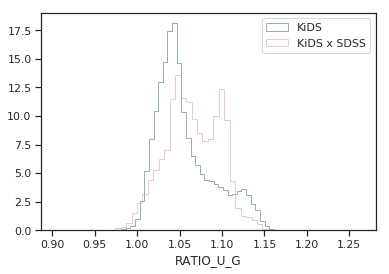

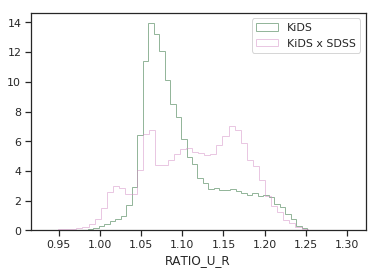

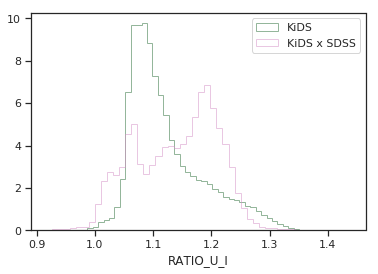

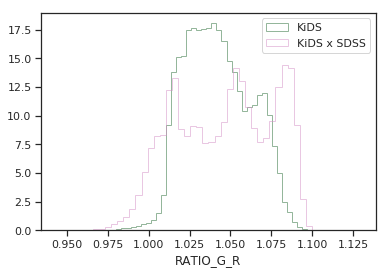

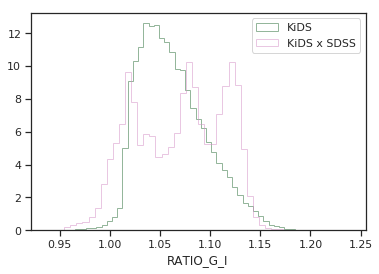

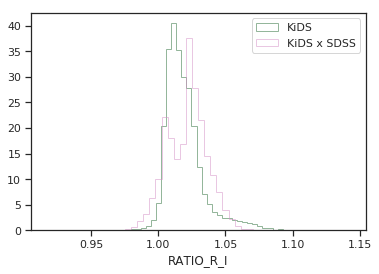

In [46]:
sns.set(style='ticks')
for c in RATIO_COLUMNS:
    plt.figure()
    sns.distplot(kids_cut[c], label='KiDS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[0])
    sns.distplot(kids_x_sdss_cut[c], label='KiDS x SDSS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True,color=color_palette[1])
    plt.legend()

# KiDS color cuts

In [31]:
kids_cut = kids.loc[kids[COLOR_GAAPHOM_U_G] > 0]
kids_x_sdss_cut = kids_x_sdss.loc[kids_x_sdss[COLOR_GAAPHOM_U_G] > 0]

In [32]:
print(kids.shape)
print(kids_cut.shape)

(89450, 47)
(68204, 47)


In [33]:
print(kids_x_sdss.shape)
print(kids_x_sdss_cut.shape)

(52010, 59)
(51062, 59)


In [34]:
print(np.unique(kids_x_sdss['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([32582,  7265, 12163]))


In [35]:
print(np.unique(kids_x_sdss_cut['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([32538,  6556, 11968]))


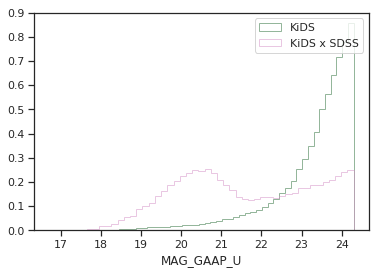

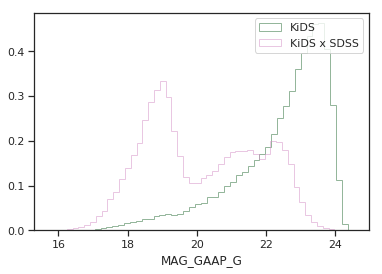

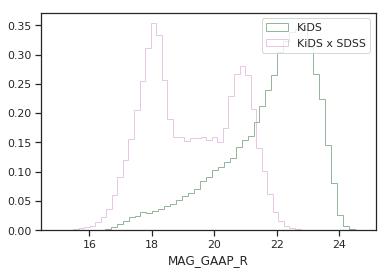

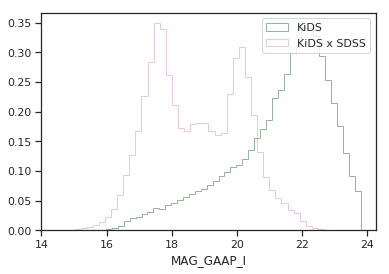

In [36]:
sns.set(style='ticks')
for c in BAND_COLUMNS:
    plt.figure()
    sns.distplot(kids_cut[c], label='KiDS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[0])
    sns.distplot(kids_x_sdss_cut[c], label='KiDS x SDSS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[1])
    plt.legend()

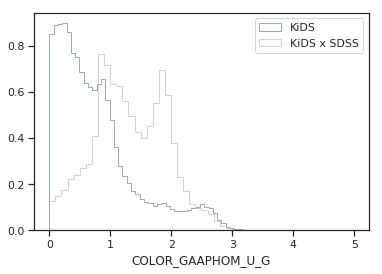

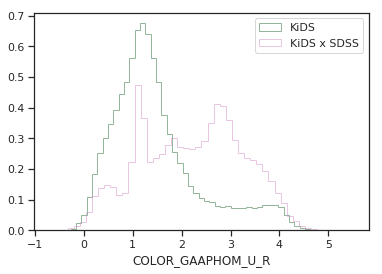

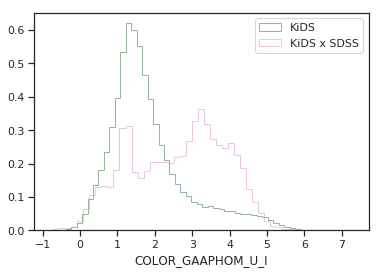

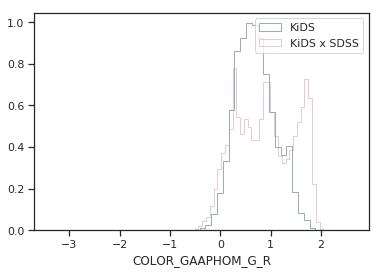

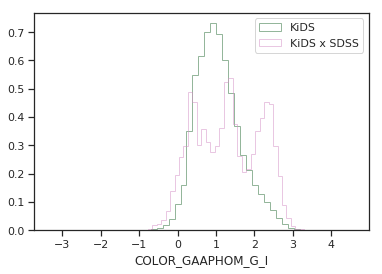

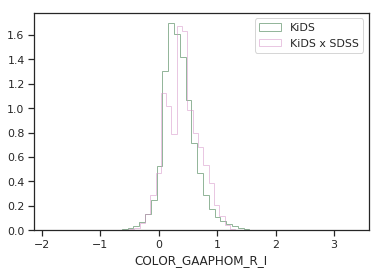

In [37]:
sns.set(style='ticks')
for c in COLOR_COLUMNS:
    plt.figure()
    sns.distplot(kids_cut[c], label='KiDS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[0])
    sns.distplot(kids_x_sdss_cut[c], label='KiDS x SDSS', kde=False, rug=False, hist_kws={'alpha': 0.5, 'histtype': 'step'},
                 norm_hist=True, color=color_palette[1])
    plt.legend()

# KiDS cuts comparison with t-SNE

In [26]:
def add_cut_label(data):
    data['cut_label'] = 'remaining'
    data.loc[data[COLOR_GAAPHOM_U_G] < 0, 'cut_label'] = 'u-g cut'
    data.loc[data[MAG_GAAP_CALIB_R] > 22, 'cut_label'] = 'r cut'
    data.loc[(data[MAG_GAAP_CALIB_R] > 22) & (data[COLOR_GAAPHOM_U_G] < 0), 'cut_label'] = 'both cuts'
    return data

In [27]:
kids_merged = kids_x_sdss.append(kids.loc[~kids['ID'].isin(kids_x_sdss['ID'])], sort=False)

In [28]:
kids_merged = add_cut_label(kids_merged)

In [29]:
kids_merged['is_in_SDSS'] = kids_merged['ID'].isin(kids_x_sdss['ID'])

In [30]:
kids_sampled = kids_merged.sample(20000, random_state=1467)

## All features

In [17]:
kids_features = MinMaxScaler().fit_transform(kids_sampled[FEATURES['all']])

In [18]:
kids_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                     n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=1,
                     random_state=1452, method='barnes_hut', angle=0.5).fit_transform(kids_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.012s...
[t-SNE] Computed neighbors for 20000 samples in 1.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


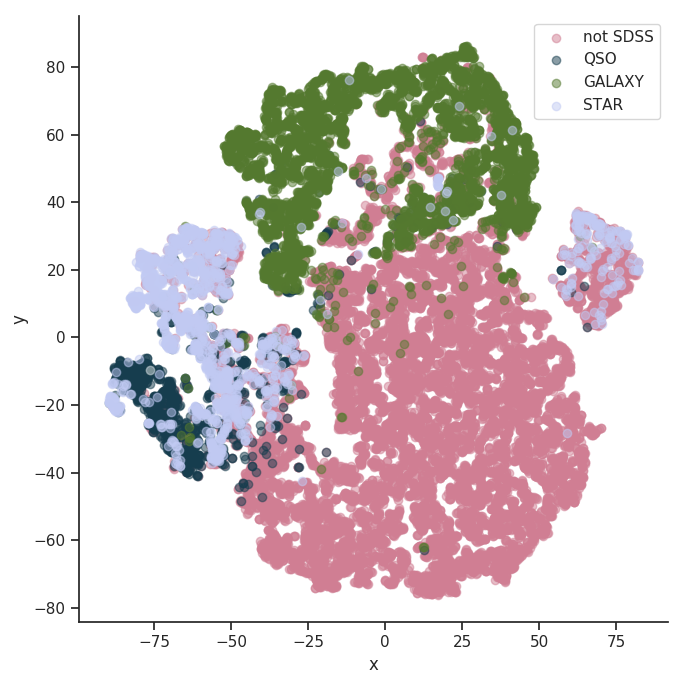

In [33]:
plot_embedding(kids_embedded, kids_sampled['CLASS'].fillna(value='not SDSS'), label='object type')

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


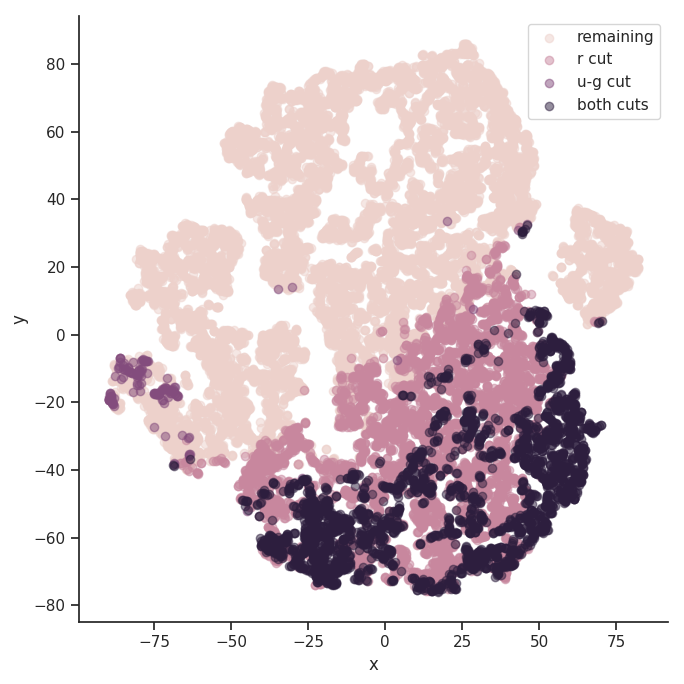

In [36]:
labels = kids_sampled['cut_label']

labels_unique = np.unique(labels)
n_colors = len(labels_unique)
color_palette = sns.cubehelix_palette(n_colors)
color_palette.reverse()

color_palette = OrderedDict([
    ('remaining', color_palette[3]),
    ('r cut', color_palette[2]),
    ('u-g cut', color_palette[1]),
    ('both cuts', color_palette[0]),
])

plot_embedding(kids_embedded, labels, label='data cut', color_palette=color_palette, with_custom_colors=False,
               labels_in_order=True)

## No magnitudes: colors, ratios, class star

In [61]:
kids_features = MinMaxScaler().fit_transform(kids_sampled[FEATURES['no-mags']])

In [62]:
kids_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                     n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=1,
                     random_state=45617, method='barnes_hut', angle=0.5).fit_transform(kids_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.010s...
[t-SNE] Computed neighbors for 20000 samples in 0.840s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

/home/snakoneczny/tools/python3/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


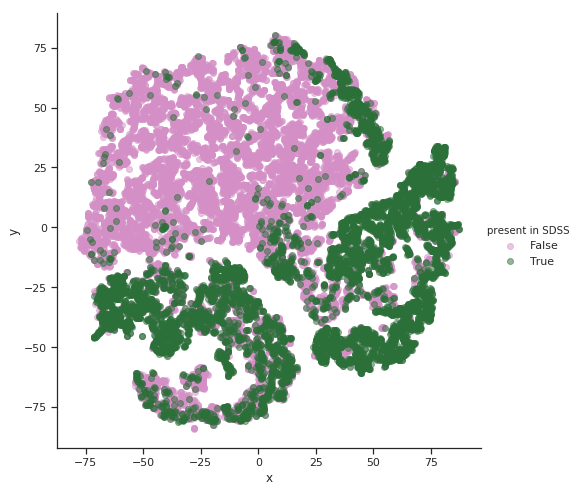

In [67]:
plot_embedding(kids_embedded, kids_sampled['is_in_SDSS'], label='present in SDSS')

/home/snakoneczny/tools/python3/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


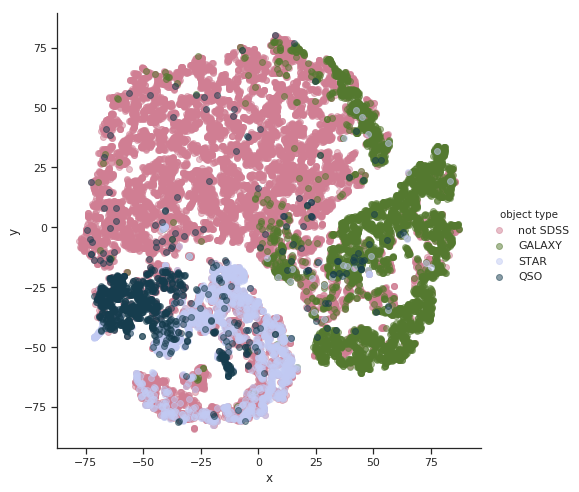

In [72]:
plot_embedding(kids_embedded, kids_sampled['CLASS'].fillna(value='not SDSS'), label='object type')

/home/snakoneczny/tools/python3/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


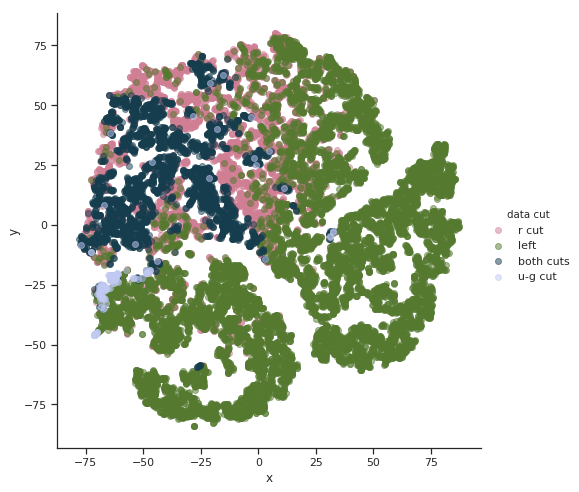

In [73]:
plot_embedding(kids_embedded, kids_sampled['cut_label'], label='data cut')

## KiDS colors + magnitudes

In [58]:
kids_features = MinMaxScaler().fit_transform(kids_sampled[FEATURES['all']])

In [59]:
kids_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                     n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=1,
                     random_state=4680, method='barnes_hut', angle=0.5).fit_transform(kids_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.010s...
[t-SNE] Computed neighbors for 20000 samples in 0.854s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

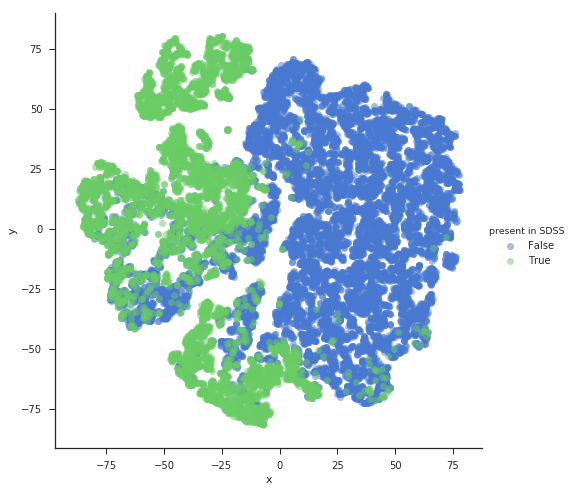

In [60]:
plot_embedding(kids_embedded, kids_sampled['is_in_SDSS'], label_name='present in SDSS')

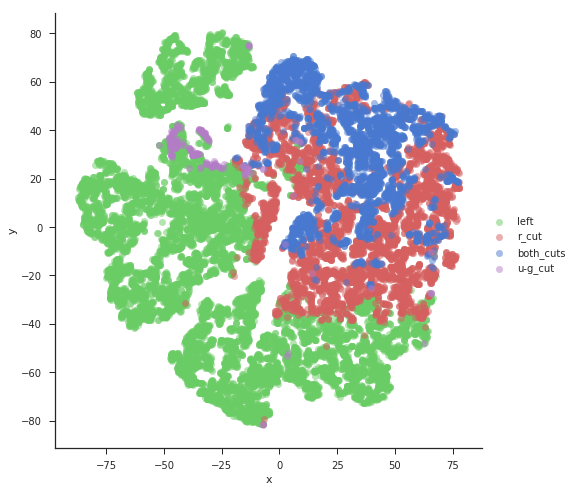

In [61]:
plot_embedding(kids_embedded, kids_sampled['cut_label'], label_name='')

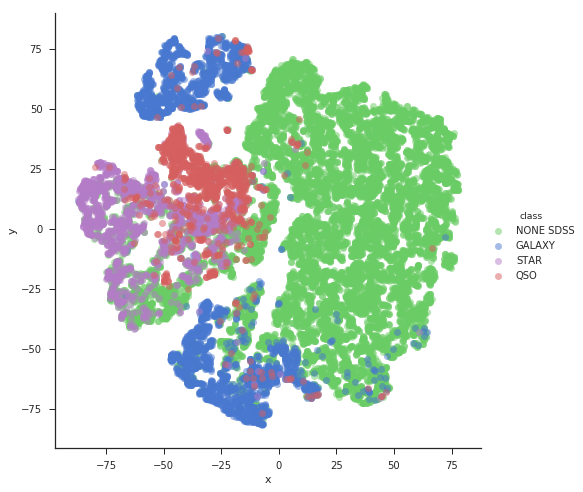

In [62]:
plot_embedding(kids_embedded, kids_sampled['CLASS'].fillna(value='NONE SDSS'))

## KiDS colors

In [63]:
kids_colors = MinMaxScaler().fit_transform(kids_sampled[FEATURES['colors-cstar']])

In [64]:
kids_colors_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                            n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=1,
                            random_state=4680, method='barnes_hut', angle=0.5).fit_transform(kids_colors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.008s...
[t-SNE] Computed neighbors for 20000 samples in 0.536s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

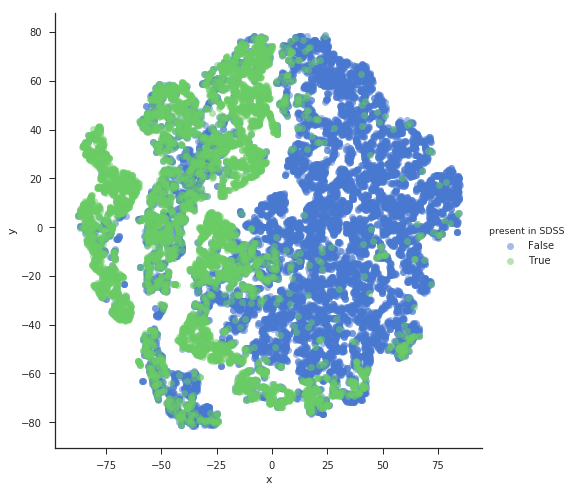

In [65]:
plot_embedding(kids_colors_embedded, kids_sampled['is_in_SDSS'], label_name='present in SDSS')

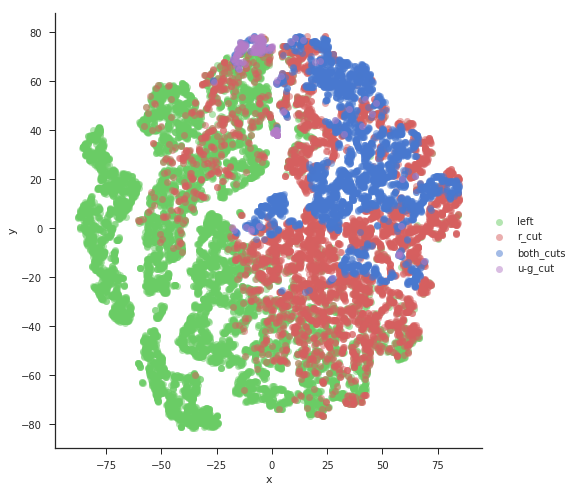

In [66]:
plot_embedding(kids_colors_embedded, kids_sampled['cut_label'], label_name='')

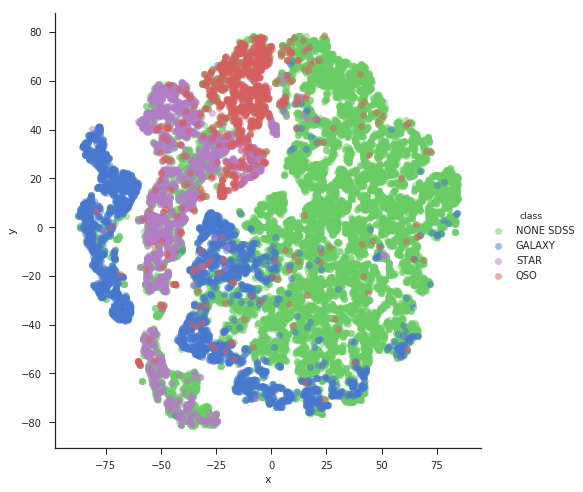

In [67]:
plot_embedding(kids_colors_embedded, kids_sampled['CLASS'].fillna(value='NONE SDSS'))

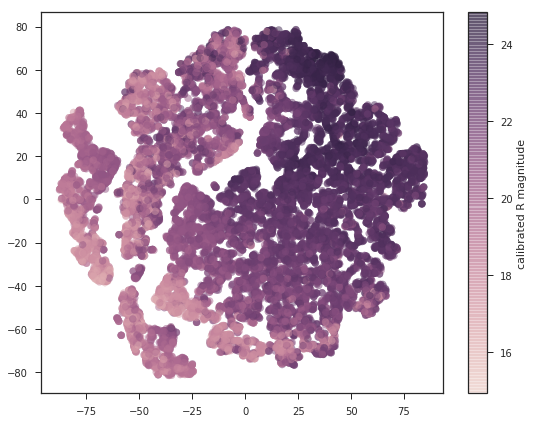

In [69]:
plot_embedding(kids_colors_embedded, kids_sampled[MAG_GAAP_CALIB_R], label='calibrated R magnitude', is_continuous=True)

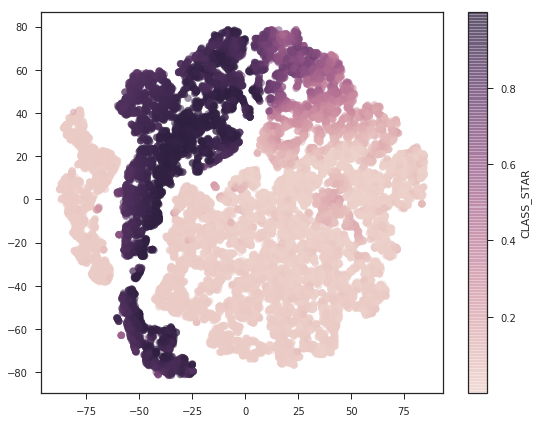

In [70]:
plot_embedding(kids_colors_embedded, kids_sampled['CLASS_STAR'], label='CLASS_STAR', is_continuous=True)

# KiDS STAR

In [62]:
kids_star = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.STAR.cols.csv')

Data shape: (4514831, 37)
Droping NANs: 4053246 left
Removing limiting magnitudes: 2286021 left
Removing errors bigger than 1: 2285941 left
Removing SExtractor flags: 1690689 left
Removing ima-flags: 1402259 left


In [64]:
kids_star_x_sdss = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.STAR.x.SDSS.DR14.cols.csv', sdss_cleaning=True)

Data shape: (30940, 42)
Droping NANs: 30679 left
Removing limiting magnitudes: 29514 left
Removing errors bigger than 1: 29514 left
Removing SExtractor flags: 23446 left
Removing ima-flags: 18829 left
Cleaning SDSS: 16056 left


## R cut

In [65]:
kids_star_cut = kids_star.loc[kids_star[MAG_GAAP_R] < 22]
kids_star_x_sdss_cut = kids_star_x_sdss.loc[kids_star_x_sdss[MAG_GAAP_R] < 22]

In [66]:
print(kids_star.shape)
print(kids_star_cut.shape)

(1402259, 41)
(1095613, 41)


In [67]:
print(kids_star_x_sdss.shape)
print(kids_star_x_sdss_cut.shape)

(16056, 46)
(15793, 46)


In [68]:
print(np.unique(kids_star_x_sdss['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  102,  5680, 10274]))


In [69]:
print(np.unique(kids_star_x_sdss_cut['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  101,  5455, 10237]))


## Color cut

In [70]:
kids_star_cut = kids_star.loc[kids_star[COLOR_GAAPHOM_U_G] > 0]
kids_star_x_sdss_cut = kids_star_x_sdss.loc[kids_star_x_sdss[COLOR_GAAPHOM_U_G] > 0]

In [71]:
print(kids_star.shape)
print(kids_star_cut.shape)

(1402259, 41)
(1342732, 41)


In [72]:
print(kids_star_x_sdss.shape)
print(kids_star_x_sdss_cut.shape)

(16056, 46)
(15287, 46)


In [73]:
print(np.unique(kids_star_x_sdss['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  102,  5680, 10274]))


In [74]:
print(np.unique(kids_star_x_sdss_cut['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([   96,  5088, 10103]))


# KiDS GAIA

In [75]:
kids_gaia = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.cols.csv')

Data shape: (1525462, 37)
Droping NANs: 1515124 left
Removing limiting magnitudes: 1359837 left
Removing errors bigger than 1: 1359825 left
Removing SExtractor flags: 913195 left
Removing ima-flags: 722284 left


In [76]:
kids_gaia_x_sdss = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.x.SDSS.DR14.cols.csv', sdss_cleaning=True)

Data shape: (29297, 42)
Droping NANs: 29210 left
Removing limiting magnitudes: 28825 left
Removing errors bigger than 1: 28825 left
Removing SExtractor flags: 19248 left
Removing ima-flags: 15009 left
Cleaning SDSS: 14438 left


## R cut

In [77]:
kids_gaia_cut = kids_gaia.loc[kids_gaia[MAG_GAAP_R] < 22]
kids_gaia_x_sdss_cut = kids_gaia_x_sdss.loc[kids_gaia_x_sdss[MAG_GAAP_R] < 22]

In [78]:
print(kids_gaia.shape)
print(kids_gaia_cut.shape)

(722284, 41)
(722277, 41)


In [79]:
print(kids_gaia_x_sdss.shape)
print(kids_gaia_x_sdss_cut.shape)

(14438, 46)
(14437, 46)


In [80]:
print(np.unique(kids_gaia_x_sdss['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([3024, 3547, 7867]))


In [81]:
print(np.unique(kids_gaia_x_sdss_cut['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([3024, 3547, 7866]))


## Color cut

In [82]:
kids_gaia_cut = kids_gaia.loc[kids_gaia[COLOR_GAAPHOM_U_G] > 0]
kids_gaia_x_sdss_cut = kids_gaia_x_sdss.loc[kids_gaia_x_sdss[COLOR_GAAPHOM_U_G] > 0]

In [83]:
print(kids_gaia.shape)
print(kids_gaia_cut.shape)

(722284, 41)
(718686, 41)


In [84]:
print(kids_gaia_x_sdss.shape)
print(kids_gaia_x_sdss_cut.shape)

(14438, 46)
(13877, 46)


In [85]:
print(np.unique(kids_gaia_x_sdss['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([3024, 3547, 7867]))


In [86]:
print(np.unique(kids_gaia_x_sdss_cut['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([3024, 3062, 7791]))
